In [31]:
import math
import operator
import numpy as np
import pandas as pd
from scipy.misc import comb
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.externals import six
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

%matplotlib inline

### 集成分类器出错率的概率密度函数

In [4]:
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier/2.0)
    probs = [comb(n_classifier,k)*error**k*(1-error)**(n_classifier-k) for k in range(int(k_start),n_classifier+1)]
    return sum(probs)

In [5]:
ensemble_error(11,0.25)

0.034327507019042969

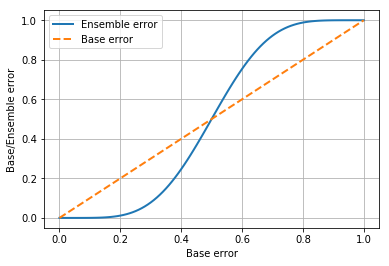

In [10]:
#画出成员分类器的出错率与集成分类器出错率之间的关系
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

从图中看到，当成员分类器的出错率低于随机猜测时(二分类的情况)，即$\epsilon <0.5$,集成分类器的出错率要低于单个分类器。 

## 多数投票分类器 stacking

In [2]:
#基于类别预测概率的加权多数投票算法
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    '''A majority vote ensemble classifier
    Parameters
    ---------------
    classifiers: array-like, shape=[n_classifiers]
        Different classifiers for the ensemble
        
    vote: str, {'classlabel', 'probability'}
        Default: 'classlabel'
            If 'classlabel' the prediction is based on
            the argmax of class labels. Else if
            'probability', the argmax of the sum of
            probabilities is used to predict the class label
            (recommended for calibrated classifiers).
            
    weights: array-like, shape=[n_classifiers]
        Optional, default: None
            If a list of `int` or `float` values are
            provided, the classifiers are weighted by 
            importance; Uses uniform weights if `weights=None`.
    '''
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        #这个是什么
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        '''Fit classifiers.
        Parameters
        --------------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.
            
        y : array-like, shape=[n_samples]
            Vector of target class labels.
            
        Returns
        --------------
        self: object
        '''
        #Use LabelEncoder to ensure class labels start
        #with 0, which is important for np.argmax
        #call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
        
    def predict(self, X):
        '''Predict class labels for X.
        
        Parameters
        ---------------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.
            
        Returns
        ---------------
        maj_vote : array-like, shape=[n_samples]
            Predicted class labels.
            
        '''
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
            
        else: #'classlabel' vote
            #Collect results form clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                     for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    #返回平均概率
    def predict_proba(self, X):
        '''Predict class probabilities for X.
        
        Parameters
        ---------------
        X : {array-like, Sparse matrix},
            shape=[n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.
        Returns
        ----------------
        avg_proba: array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.
        '''
        probas = np.asarray([clf.predict_proba(X)
                            for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        '''Get classifier parameter names for GridSearch'''
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out
            

多数分类器说明：使用两个基类BaseEstimator和ClassifierMixin获取某些基本方法（set_params，get_params，score方法均来自这些基类）。导入six包从而使得MajorityVoteClassifier与Python2.7兼容。
predict_proba方法来返回平均概率，这在计算AUC时需要用到。
通过get_params方法来获取集成分类器中独立成员函数的参数。

In [4]:
#读取数据集对多数分类器进行测试
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [5]:
#五五划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [7]:
#先通过10折交叉验证看一下各个分类器在训练数据集上的性能表现
clf1 = LogisticRegression(penalty='l2', C=0.002, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
#使用逻辑斯蒂回归算法作为pipeline的一部分
pipe1 = Pipeline([['sc', StandardScaler()],['clf', clf1]])

#使用K近邻算法作为pipeline的一部分
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print ('10-ford cross validation: \n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10-ford cross validation: 

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [8]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print ('Accuraty: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

Accuraty: 0.92 (+/- 0.20) [Logistic Regression]
Accuraty: 0.92 (+/- 0.15) [Decision Tree]
Accuraty: 0.93 (+/- 0.10) [KNN]
Accuraty: 0.97 (+/- 0.10) [Majority Voting]


以10折交叉验证作为评估标准，MajorityVotingClassifier的性能与单个成员分类器相比有着质的提高

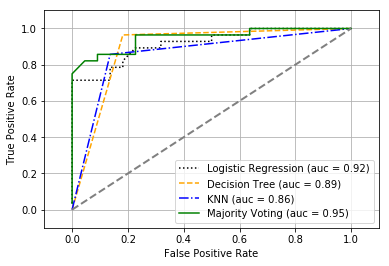

In [10]:
#在测试数据上计算Majority VoteClassifier 类的ROC曲线，以验证其在未知数据上的泛化性能
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    #assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

从ROC图我们可以看到，集成分类器在测试集上表现优秀(ROC AUC = 0.95),而k近邻分类器对于训练数据有些过拟合(训练集上的ROC AUC=0.93,测试集上ROC AUC=0.86）

(3534, 2)
(2, 3534)


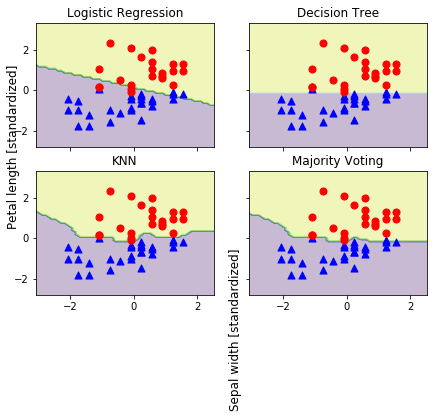

In [12]:
#对数据集进行标准化
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

#分别画出成员分类函数的决策边界
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))

print(np.c_[xx.ravel(), yy.ravel()].shape)
print(np.array([xx.ravel(), yy.ravel()]).shape)

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    test_x = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(test_x)
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='red', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.text(-10.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

可以看到多数分类器在sepal width>=1时正交于y轴

In [13]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_split': 1e-07,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_

In [15]:
#使用网格搜索来调整逻辑斯谛回归分类器的正则化系数C以及决策树深度
#网格搜索原理说明：通过传递不同的值给成员函数的超参数，并计算出对应的roc_auc值，从而，找出最佳的超参数取值
params = {'decisiontreeclassifier__max_depth': [1,2],
          'pipeline-1__clf__C':[0.001,0.1,100.0]}
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/x%0.2f %r" % (mean_score, scores.std()/2, params))

0.967+/x0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1}
0.967+/x0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1}
1.000+/x0.00 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
0.967+/x0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2}
0.967+/x0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2}
1.000+/x0.00 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 2}


In [16]:
#如结果所见，当选择正则化强度较小时，能够得到最佳的交叉验证结果，而决策数的深度似乎对性能没有任何影响，这意味着使用单层决策书足以对数据进行划分
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
Accuracy: 1.00


当选择的正则化强度较小时，我们能够得到最佳的交叉验证结果，而决策树的深度似乎对性能没有任何影响，这意味着使用单层决策树足以对数据进行划分。注意，在对模型评估时，不止一次使用同一个测试集并非一个好做法。

# bagging
提高不稳定模型的准确率，并且可以降低过拟合的程度。

In [19]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [20]:
#使用第四章的葡萄酒数据集构建一个更为复杂的分类问题，只考虑葡萄酒类别2和类别3,且只选择Alcohol,Hue这两个特征
df_wine.columns = ['Class label', 'Alcohol', 
                   'Malic acid', 'Ash',
                   'Alcalinity of ash',
                   'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [23]:
#将类标编码为二进制形式，划分训练集和测试集
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

In [24]:
#使用未剪枝的决策树作为成员分类器，并在训练集上通过不同的bootstrap抽样拟合500颗决策树
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [26]:
#计算训练集和测试集上的预测准确率，以比较bagging分类器与单颗未剪枝决策树的性能差异

#单颗未剪枝决策树
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [27]:
#bagging分类器
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.896


以上两中情况的对比结论：虽然决策树和bagging分类器在训练集上的准确率相似， 但是bagging分类器在测试数据上的泛化能力略胜一筹

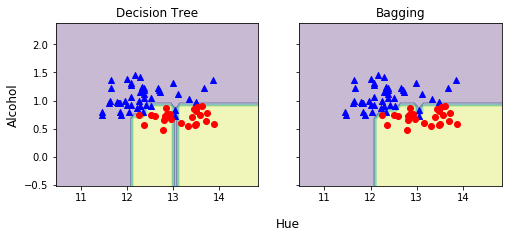

In [28]:
#比较决策树和bagging分类器的决策边界
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(8,3))
for idx, clf, tt in zip([0,1],[tree,bag],['Decision Tree','Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                       X_train[y_train==1, 1],
                       c='red', marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center',va='center', fontsize=12)
plt.show()

# 总结
1. 未剪枝决策树属于低偏差分类器 
2. 分类任务更复杂，数据集维度更高的使用，单颗决策树容易产生过拟合
3. bagging算法在降低模型方差方面效果显著，但是在降低模型偏差方面作用不大

# boosting

In [29]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

In [32]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,random_state=0)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.967/0.875


In [33]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('Adaboost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

Adaboost train/test accuracies 0.983/0.900


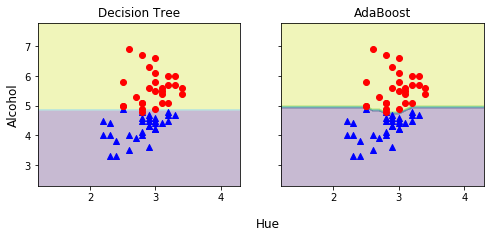

In [34]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1,2,sharex='col',sharey='row', figsize=(8,3))
for idx, clf, tt in zip([0,1],[tree, ada],['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0],
                       X_train[y_train==0, 1],
                       c='blue',
                       marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                       X_train[y_train==1, 1],
                       c='red',
                       marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(1, 1, s='Hue',ha='center',va='center',fontsize=12)
plt.show()